In [1]:
import torch
import torch.nn as nn

from hvsrUNet.module.model import UNet
from hvsrUNet.module.trainer import train
from hvsrUNet.module.dataset import MkData
from hvsrUNet.toolbox.plot import plotTest, plotLoss
from hvsrUNet.toolbox.hvsrIO import saveModel, loadModel

In [2]:
dataset = MkData(sampleNum=512, layerNum=3, num_h1=20, num_h2=20, dx=0.8, depth_end=200., freqs_end=10)
train_iter, test_iter = dataset.getIter()

# define model
model = nn.Sequential(
    UNet(1, 1)
    )

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [ ]:
# train 
epochs = 5
model, losses = train(model, criterion, optimizer, train_iter, num_epochs=epochs)

In [ ]:
## model parameters pt file name: freqs_end, num_v1, num_v2, num_v3, num_h1, num_h2, sampleNum
#                                 10.        4.      8.      2.     20.      20.     5.
#saveModel(model, optimizer, epochs, losses, '../data/10_4_8_2_20_20_5.pt')

In [3]:
model, optimizer, epochs, losses = loadModel(model, optimizer, '../data/10_4_8_2_20_20_5.pt')

In [ ]:
plotLoss(losses)

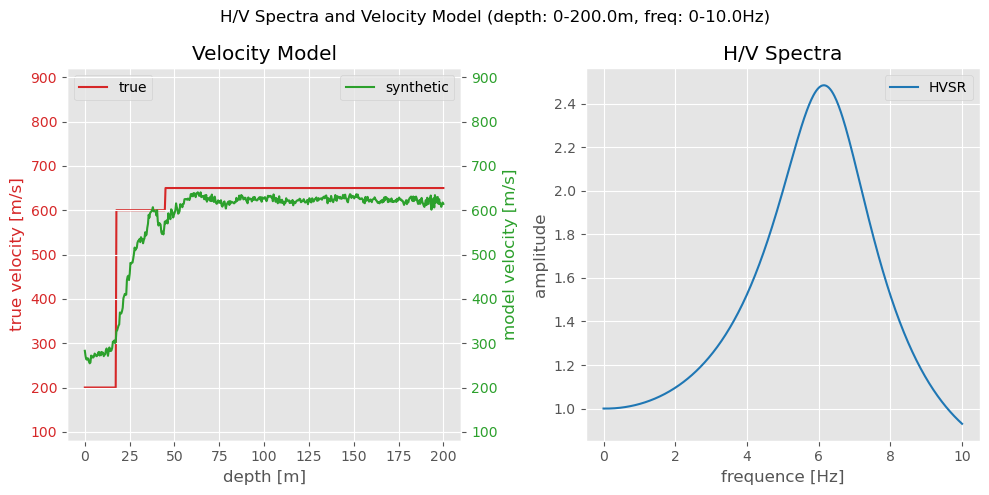

In [9]:
plotTest(model, test_iter, depth_end=200., freqs_end=10)

In [5]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

hv_true = np.loadtxt('hv.hv')
hv_true = signal.resample(hv_true, 512)

In [6]:
X, yy = next(iter(test_iter))

hv = torch.tensor(hv_true[:, 0], dtype=torch.float32)
hv = hv.reshape(1, 1, 1, len(hv_true[:, 0]))
hv = torch.cat((hv, hv), dim=0)

y = model(hv)

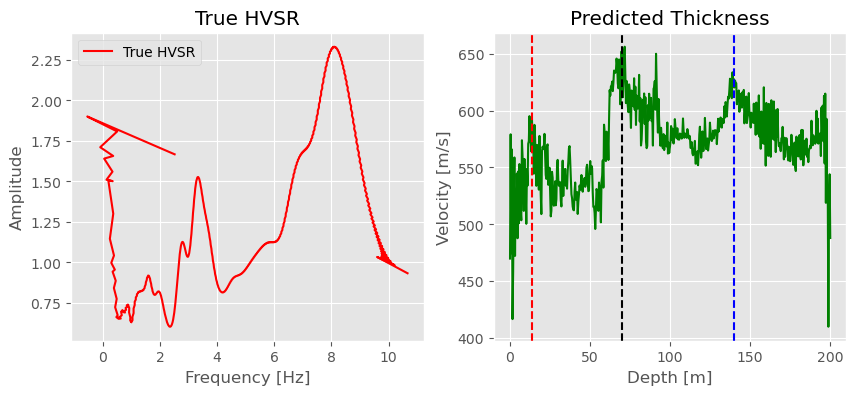

In [7]:
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(10, 4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(hv_true[:, 0], hv_true[:, 1], label='True HVSR', color='red')
    ax1.set_title('True HVSR')
    ax1.set_xlabel('Frequency [Hz]')
    ax1.set_ylabel('Amplitude')
    ax1.legend(loc='upper left')


    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(np.linspace(0, 200, 512), 100*y[0][0][0].detach().numpy(), label='Predicted Thickness', color='green')
    ax2.set_title('Predicted Thickness')
    ax2.set_xlabel('Depth [m]')
    ax2.set_ylabel('Velocity [m/s]')
    #ax2.legend(loc='upper right')
    ax2.axvline(x=14, color='r', linestyle='--') #ymin=0.2, ymax=0.8
    ax2.axvline(x=70, color='k', linestyle='--')
    ax2.axvline(x=140, color='b', linestyle='--')
    